In [1]:
import utils
from hopfield import HopfieldNeuralNetwork
import numpy as np
import random
import time
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('seaborn')

### Relation between Maximum Independent Set, Maximum Clique, and Minimum Vertex Cover Problem

![graph](https://upload.wikimedia.org/wikipedia/commons/e/ee/Mis_related_sets.png)

Corresponding weight matrices for the above graphs:
$$
W_1 = \left[
\begin{matrix}
0 & 1 & 1 & 0 & 0 & 0 \\
1 & 0 & 1 & 1 & 0 & 0 \\
1 & 1 & 0 & 1 & 0 & 0 \\
0 & 1 & 1 & 0 & 1 & 1 \\
0 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0
\end{matrix}
\right] \quad

W_2 = \left[
\begin{matrix}
0 & 0 & 0 & 1 & 1 & 1 \\
0 & 0 & 0 & 0 & 1 & 1 \\
0 & 0 & 0 & 0 & 1 & 1 \\
1 & 0 & 0 & 0 & 0 & 0 \\
1 & 1 & 1 & 0 & 0 & 1 \\
1 & 1 & 1 & 0 & 1 & 0
\end{matrix}
\right] \quad

W_3 = \left[
\begin{matrix}
0 & 1 & 1 & 0 & 0 & 0 \\
1 & 0 & 1 & 1 & 0 & 0 \\
1 & 1 & 0 & 1 & 0 & 0 \\
0 & 1 & 1 & 0 & 1 & 1 \\
0 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0
\end{matrix}
\right]
$$
And node weights:
$$
W_N = \{2, 3, 1, 5, 3, 3\}
$$

Solutions to the above problems:
$$
\begin{align*}
\text{MIS}(W_1) &= \{2, 5, 6\} \\
\text{MC}(W_2) &= \{2, 5, 6\} \\
\text{MVC}(W_3) &= \{1, 3, 4\} \\
\end{align*}
$$

1. Solution to a Maximum Independent Set problem
2. Solution to a Maximum Clique problem
3. Solution to a Minimum Vertex Cover problem

In [2]:
mwis = utils.MaxWeightedIndependentSet()

# Edge weights
G = np.array([[0,1,1,0,0,0],
              [1,0,1,1,0,0],
              [1,1,0,1,0,0],
              [0,1,1,0,1,1],
              [0,0,0,1,0,0],
              [0,0,0,1,0,0]])

# Node weights
Gn = np.array([2, 3, 1, 5, 3, 3])

print(G.shape)

W = -len(Gn) * abs(Gn.max()) * G
Wn = -Gn

ones = np.ones(W.shape[0])

# Bias vector in terms of node weights and edge weights
b = W.T @ ones - 4 * np.array(Wn)

hnn = HopfieldNeuralNetwork(weights=W, bias=b, mode='ExponentialSmoothing')
n_steps = 500
n_epochs = 100

# alpha_evol = np.linspace(0, 1, n_steps)
alpha_evol = np.logspace(5, -5, n_steps)
energies = np.zeros((n_epochs, n_steps))
idx_state = utils.PermutationStates(hnn.n_neurons)


def find_indep_set(hnn, n_steps, epoch, batch_size=0):
  '''`batch_size` lies in [0, 1]. If `batch_size` is 0, a single state of x is updated
  at a time. If `batch_size` is 1, all states of x are updated at a time.'''
  x = np.random.choice([-1, 1], size=hnn.n_neurons)
  for i, alpha in zip(range(n_steps), alpha_evol):
    if batch_size == 0: idx = idx_state.next()
    else: idx = random.sample(range(hnn.n_neurons), int(np.ceil(batch_size*hnn.n_neurons)))
    x[idx] = hnn.predict(x, alpha=alpha, indices=idx)
    energies[epoch][i] = mwis.energy(x, hnn.W, hnn.b)
  set_weight = mwis.energy(x, hnn.W, hnn.b)
  return set_weight, x

start = time.perf_counter()
best_set_energy = np.inf
max_indep_set = None
for e in range(n_epochs):
  set_weight, y = find_indep_set(hnn, n_steps, e)
  # print(f'Epoch {e+1}: {set_weight}, {y}')
  if set_weight < best_set_energy:
    best_set_energy = set_weight
    max_indep_set = y

print(f'Max Independent Set Weight: {best_set_energy}')
print(f'Finished in {time.perf_counter()-start:.2f} seconds')

(6, 6)


d:\Desktop\mem-HNNs\sims\hopfield.py:69: RuntimeWarning: overflow encountered in exp
  alpha/(np.exp(alpha/(self.W[self.idx]-self.W_avg)) - 1),
d:\Desktop\mem-HNNs\sims\hopfield.py:70: RuntimeWarning: overflow encountered in exp
  - alpha/(np.exp(alpha/(self.W_avg-self.W[self.idx])) - 1))
d:\Desktop\mem-HNNs\sims\hopfield.py:72: RuntimeWarning: overflow encountered in exp
  alpha/(np.exp(alpha/(self.b[self.idx]-self.b_avg)) - 1),
d:\Desktop\mem-HNNs\sims\hopfield.py:73: RuntimeWarning: overflow encountered in exp
  - alpha/(np.exp(alpha/(self.b_avg-self.b[self.idx])) - 1))


Max Independent Set Weight: -9.0
Finished in 8.24 seconds


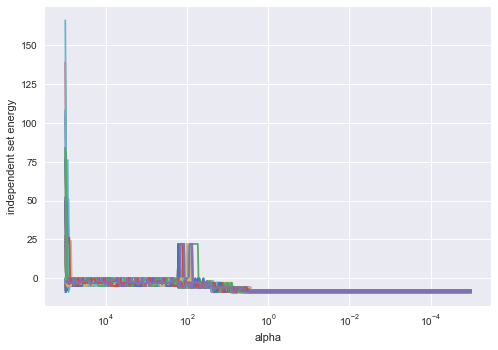

In [3]:
for e in range(n_epochs): plt.plot(alpha_evol, energies[e])
plt.xscale('log')
plt.gca().invert_xaxis()
plt.xlabel('alpha')
plt.ylabel('independent set energy')
plt.savefig('indep_set_energies.png')

In [4]:
max_indep_set

array([-1,  1, -1, -1,  1,  1])

In [5]:
# Verifying the result by brute force
import itertools

ans = np.inf
y_ans = None
for y in np.array(list(map(list, itertools.product([-1, 1], repeat=6)))):
  if ans > mwis.energy(y, W, b):
    ans = mwis.energy(y, W, b)
    y_ans = y
print(ans, y_ans)

-9.0 [-1  1 -1 -1  1  1]


Worst independent set energy: -8.0


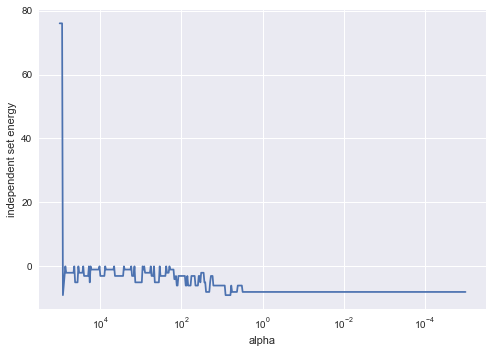

In [6]:
i = np.argmax(energies[:,-1])
print(f'Worst independent set energy: {energies[i][-1]}')
plt.plot(alpha_evol, energies[i])
plt.xscale('log')
plt.gca().invert_xaxis()
plt.xlabel('alpha')
plt.ylabel('independent set energy')
plt.show()

Best independent set energy: -9.0


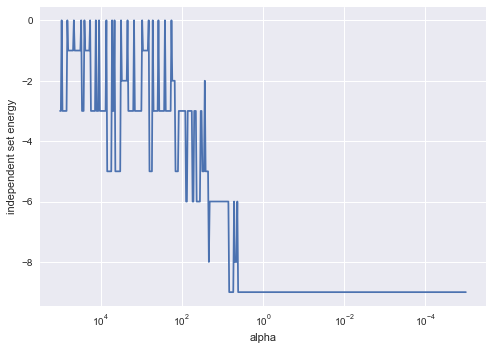

In [7]:
i = np.argmin(energies[:,-1])
print(f'Best independent set energy: {energies[i][-1]}')
plt.plot(alpha_evol, energies[i])
plt.xscale('log')
plt.gca().invert_xaxis()
plt.xlabel('alpha')
plt.ylabel('independent set energy')
plt.show()